In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Ipynb_importer
from utils_x import *
from parameters_x import *
import seaborn as sns
import datetime
sns.set(style="darkgrid")

importing Jupyter notebook from utils_x.ipynb
importing Jupyter notebook from parameters_x.ipynb


In [2]:
print("------------------- load data--------------------")
data = pd.read_csv('index500_v3_adjustment.csv')
data["date_time"]  = pd.to_datetime(data["date_time"])
del data["Unnamed: 0"]

print("------------------- limit_tag--------------------")
gb = data.groupby(['unique_symbol'])['adjustment_cumsum']
data['t+1_adjustment_cumsum'] = gb.transform(lambda x: x.shift(-1))
data["limit_tag"]  = (data["t+1_open"] - data["t+1_adjustment_cumsum"] + data["adjustment_cumsum"]) /data["close"] -1
data["limit_tag"] = data["limit_tag"].apply(lambda x: 1 if x >= 0.099 else 0)

------------------- load data--------------------
------------------- limit_tag--------------------


In [3]:
data["use_tag"]

0          0
1          0
2          1
3          1
4          1
          ..
4560223    0
4560224    0
4560225    0
4560226    0
4560227    0
Name: use_tag, Length: 4560228, dtype: int64

In [4]:
print("---------------- stationary pre--------------------")
data["r"] = data["close"]/ data["open"] - 1
data["amplitude"] = (data["high"] - data["low"]) / data["close"]
data["amplitude_ratio"] =  abs((data["close"] - data["open"])/(data["high"] - data["low"]))
gb = data.groupby(['date_time'])['open']
data['open'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['close']
data['close'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['turnover']
data['turnover'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['volume']
data['volume'] = gb.transform(lambda x: (x-x.mean())/x.std())

print(data)
n_shift = 15
n_adjustment = []
for i in range(1,n_shift):
    n_adjustment.append("adjustment_cumsum"+str(i))

n_use_f = set(np.array(['unique_symbol', 'date_time', 't+1_open','t+2_open', 'return', 'label', 'rank_label', "use_tag", "adjustment"
                        ,'t+2_adjustment', "y_open", "adjustment_cumsum", 't+1_adjustment_cumsum', "limit_tag"]))
n_use_f = n_use_f | set(n_adjustment)
use_f = list(set(np.array(data.columns)) - n_use_f)
print(sorted(use_f))
print(len(use_f))

---------------- stationary pre--------------------
         unique_symbol  date_time     close  turnover      open   high    low  \
0                  691 2010-01-29 -0.157940 -0.060124 -0.158468   5.78   5.49   
1               600200 2010-01-29 -0.170310 -0.070259 -0.168612   4.80   4.64   
2               600189 2010-01-29 -0.109720 -0.068480 -0.107873   9.69   9.42   
3               600190 2010-01-29 -0.156425 -0.069636 -0.153522   5.92   5.81   
4               600191 2010-01-29 -0.124741 -0.058415 -0.123090   8.45   8.17   
...                ...        ...       ...       ...       ...    ...    ...   
4560223         300527 2017-12-27  0.068018 -0.057940  0.064833  24.40  23.71   
4560224         300528 2017-12-27 -0.091434 -0.061416 -0.090116  12.55  12.30   
4560225         300529 2017-12-27  0.173174 -0.057741  0.177351  32.43  31.60   
4560226         300530 2017-12-27  0.234206 -0.066061  0.232932  36.30  35.81   
4560227         300559 2017-12-27  0.258811 -0.065342  0.

In [5]:
data["use_tag"]

0          0
1          0
2          1
3          1
4          1
          ..
4560223    0
4560224    0
4560225    0
4560226    0
4560227    0
Name: use_tag, Length: 4560228, dtype: int64

In [6]:
data =  data[data["use_tag"] == 1].copy()
data = data.dropna(how='any',axis=0)
df  = data[data["date_time"].dt.year == 2014]
print(len(df))
data = data[~data['return'].isnull()].copy()
df  = data[data["date_time"].dt.year == 2014]
print(len(df))
      
print("-------------------- train -----------------------")
for i in range(1):
    
    t1 = datetime.datetime(2010,1,1)
    t2 = datetime.datetime(2013,1,1)
    t3 = datetime.datetime(2014,1,1)
    t4 = datetime.datetime(2015,1,1)
    data_tr = data[ (data["date_time"] >= t1)&(data["date_time"] < t2)]
    data_te = data[ (data["date_time"] >= t2)&(data["date_time"] < t3)]
    data_fin = data[ (data["date_time"] >= t3)&(data["date_time"] < t4)]
    print(len(data_tr["date_time"]))
    print(len(data_te["date_time"]))
    print(len(data_fin["date_time"]))
    
    X_train = data_tr[use_f]
    y_train = data_tr['label']
    X_test = data_te[use_f]
    y_test = data_te['label']

    market_return = list(data[data["date_time"].isin(list(data_fin.date_time))].groupby(['date_time'])['return'].mean())
    print(params)
    bst = train_op(X_train, y_train, params, num_rounds, X_test, y_test, early)  
    importance_dic = f_importance(bst, use_f)
    preds = bst.predict(xgb.DMatrix(data_fin[use_f]), ntree_limit=bst.best_ntree_limit)
    data_fin["preds"] = list(preds)
    


116302
116302
-------------------- train -----------------------
337528
116178
116302
{'task': 'train', 'booster': 'dart', 'max_depth': 6, 'subsample': 0.9, 'colsample_bytree': 0.9, 'rate_drop': 0.1, 'skip_drop': 0.5, 'nthread': 10, 'alpha': 100}


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-rmse:0.994913	eval-rmse:1.00057
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 45 rounds.
[1]	train-rmse:0.961705	eval-rmse:0.966579
[2]	train-rmse:0.98409	eval-rmse:0.948691
[3]	train-rmse:0.935459	eval-rmse:0.939503
[4]	train-rmse:0.930657	eval-rmse:0.934823
[5]	train-rmse:0.931638	eval-rmse:0.932158
[6]	train-rmse:0.926748	eval-rmse:0.931116
[7]	train-rmse:0.936633	eval-rmse:0.942002
[8]	train-rmse:0.948174	eval-rmse:0.929649
[9]	train-rmse:0.924219	eval-rmse:0.934881
[10]	train-rmse:0.926056	eval-rmse:0.943498
[11]	train-rmse:0.923812	eval-rmse:0.92958
[12]	train-rmse:0.923096	eval-rmse:0.928557
[13]	train-rmse:0.922392	eval-rmse:0.928288
[14]	train-rmse:0.924027	eval-rmse:0.944198
[15]	train-rmse:0.921908	eval-rmse:0.928151
[16]	train-rmse:0.92298	eval-rmse:0.930104
[17]	train-rmse:0.93119	eval-rmse:0.927951
[18]	train-rmse:0.92673	eval-rmse:0.927846
[19]	train-rmse:0.920491	eval-rmse:0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
gb = data_fin.groupby(['date_time'])['preds']
rank_level = 10
data_fin["pred_rank"] = gb.transform(lambda x: pd.qcut(x.rank(method='first'), rank_level, labels=False, duplicates="drop"))
portfolio_df = data_fin[data_fin["pred_rank"] == rank_level-1]
portfolio_limit_df = portfolio_df[portfolio_df["limit_tag"] ==0] 
portfolio_return = portfolio_df.groupby(["date_time"])["return"].mean()
marker_return = portfolio_df.groupby(["date_time"])["return"].mean()
data_fin["market_return"] = data_fin.groupby(["date_time"])["return"].transform("mean")
portfolio_limit_return = portfolio_limit_df.groupby(["date_time"])["return"].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
gb1 = data_fin.groupby(['date_time'])['return']
day_pred = []
for _, x in gb1:
    print(_, len(x))
    day_pred.append(np.array(x)[:450])

2014-01-02 00:00:00 488
2014-01-03 00:00:00 485
2014-01-06 00:00:00 487
2014-01-07 00:00:00 487
2014-01-08 00:00:00 488
2014-01-09 00:00:00 489
2014-01-10 00:00:00 490
2014-01-13 00:00:00 489
2014-01-14 00:00:00 488
2014-01-15 00:00:00 488
2014-01-16 00:00:00 488
2014-01-17 00:00:00 486
2014-01-20 00:00:00 484
2014-01-21 00:00:00 485
2014-01-22 00:00:00 484
2014-01-23 00:00:00 486
2014-01-24 00:00:00 488
2014-01-27 00:00:00 488
2014-01-28 00:00:00 489
2014-01-29 00:00:00 489
2014-01-30 00:00:00 489
2014-02-07 00:00:00 488
2014-02-10 00:00:00 485
2014-02-11 00:00:00 486
2014-02-12 00:00:00 486
2014-02-13 00:00:00 484
2014-02-14 00:00:00 484
2014-02-17 00:00:00 479
2014-02-18 00:00:00 479
2014-02-19 00:00:00 481
2014-02-20 00:00:00 478
2014-02-21 00:00:00 479
2014-02-24 00:00:00 479
2014-02-25 00:00:00 481
2014-02-26 00:00:00 481
2014-02-27 00:00:00 482
2014-02-28 00:00:00 483
2014-03-03 00:00:00 482
2014-03-04 00:00:00 482
2014-03-05 00:00:00 483
2014-03-06 00:00:00 480
2014-03-07 00:00

avg: 0.04160549544131872


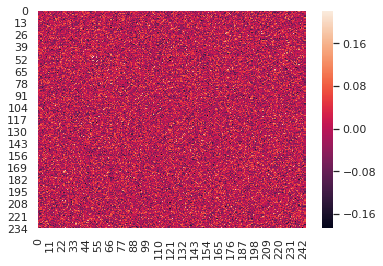

In [9]:
q = np.corrcoef(day_pred)
print("avg:", np.mean(np.abs(q)))
for i in range(len(q)):
    q[i][i]=0
sns.heatmap(q)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


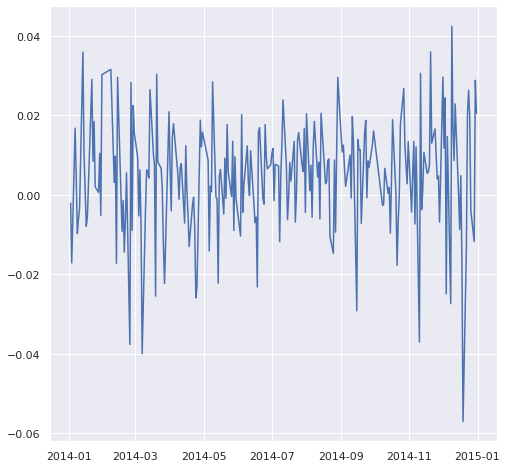

In [10]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(portfolio_return)

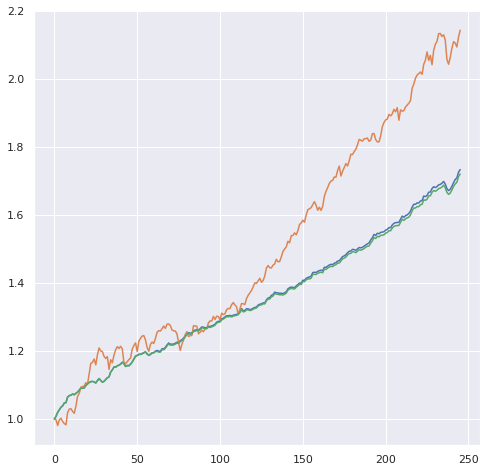

In [11]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(add_return(np.array(portfolio_return)-np.array(market_return)))
plt.plot(add_return(np.array(portfolio_return)))
plt.plot(add_return(np.array(portfolio_limit_return)-np.array(market_return)))

In [12]:
def plot_conditional_expectation(x, y, quantile_n = 20):
    step = 1 / quantile_n
    bin_cut = np.percentile(x, list(np.append(np.arange(0,1,step), 1)*100) )
    bin_cut = np.unique(bin_cut)
    tmp = pd.DataFrame({'x':x.flatten(), 'y':y.flatten()})
    tmp['bin_cut'] = pd.cut(tmp['x'],bin_cut,include_lowest=True)
    groupby_mean = tmp.groupby('bin_cut').mean().reset_index()

    plt.figure(figsize=(12,4))
    plt.plot(groupby_mean['x'], groupby_mean['y'], '-o')
    plt.axvline(x=0, color='r', ls='-.')
    plt.axhline(y=0, color='r', ls='-.')
    plt.show()
        
    return groupby_mean

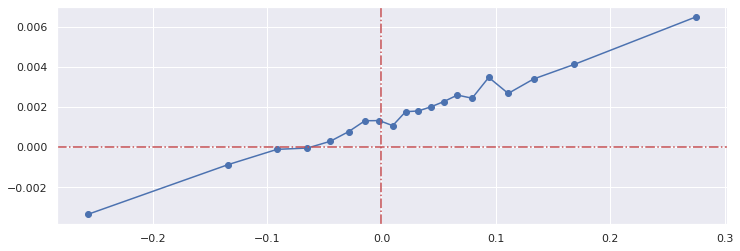

,bin_cut,x,y
0,"(-0.775, -0.166]",-0.256838,-0.003356
1,"(-0.166, -0.109]",-0.133854,-0.000871
2,"(-0.109, -0.0763]",-0.091241,-0.000113
3,"(-0.0763, -0.054]",-0.064670,-0.000047
4,"(-0.054, -0.0362]",-0.044729,0.000289
5,"(-0.0362, -0.0212]",-0.028559,0.000775
6,"(-0.0212, -0.00809]",-0.014504,0.001312
7,"(-0.00809, 0.00399]",-0.001915,0.001320
8,"(0.00399, 0.0156]",0.009798,0.001069
9,"(0.0156, 0.0266]",0.021075,0.001764


In [13]:
plot_conditional_expectation( np.array(data_fin["preds"]),np.array(data_fin["return"]))

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


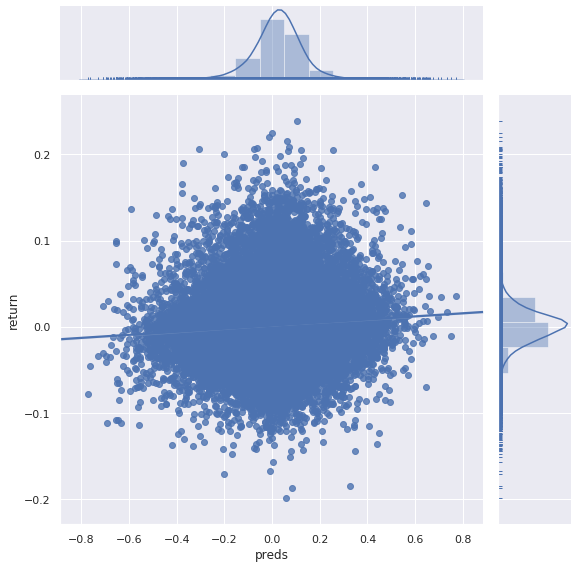

In [14]:
sns.jointplot(
              x = data_fin["preds"], y = data_fin["return"], 
              data = data_fin,  #设置数据                                 
              kind="reg",                                     
              size = 8, #图表大小(自动调整为正方形))             
              ratio = 5, #散点图与布局图高度比，整型             
              marginal_kws = dict(bins=15, rug =True),              
             )

In [15]:
for i in range(10):
    temp_df = data_fin[data_fin["pred_rank"] == i ]
    print(i, np.corrcoef(temp_df["return"] - temp_df["market_return"], temp_df["preds"])[0,1])

0 0.0525837405146552
1 0.009004560591399273
2 0.01550541866039204
3 0.007377291047491129
4 0.00908577774628752
5 -0.00511429008072876
6 0.027239747459402264
7 0.006798423450216392
8 0.028288738617602626
9 0.06182344230269501


In [16]:
for i in range(10):
    temp_df = data_fin[data_fin["pred_rank"] == i ]
    print(i, np.corrcoef(temp_df["return"], temp_df["preds"])[0,1])

0 0.061094202470446
1 0.007445466514587715
2 0.011174806176661452
3 0.005869647704527257
4 0.008421617461189058
5 0.0022249464833511263
6 0.02915303414674765
7 0.019846062840896822
8 0.0445081573800557
9 0.06589776886238942


In [17]:
np.corrcoef(data_fin["rank_label"], data_fin["pred_rank"])[0,1]

0.09868337661759267

In [18]:
np.corrcoef(data_fin["return"] - data_fin["market_return"] , data_fin["preds"])[0,1]

0.0889054335900687

In [19]:
np.corrcoef(data_fin["return"], data_fin["preds"])[0,1]

0.08016054509727759

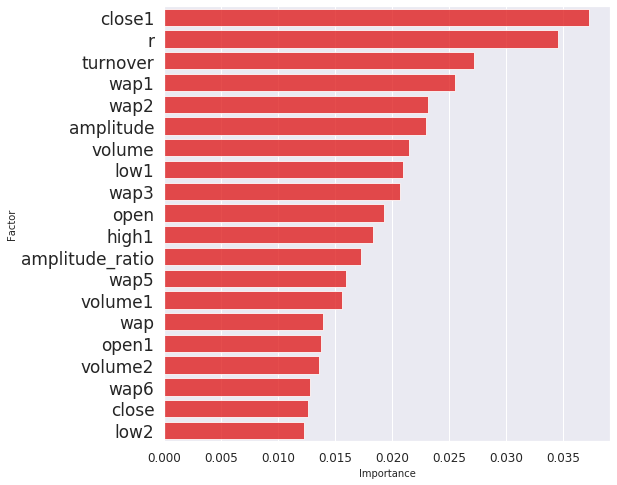

In [20]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.tick_params(labelsize=12)
f_importance_bar(importance_dic)

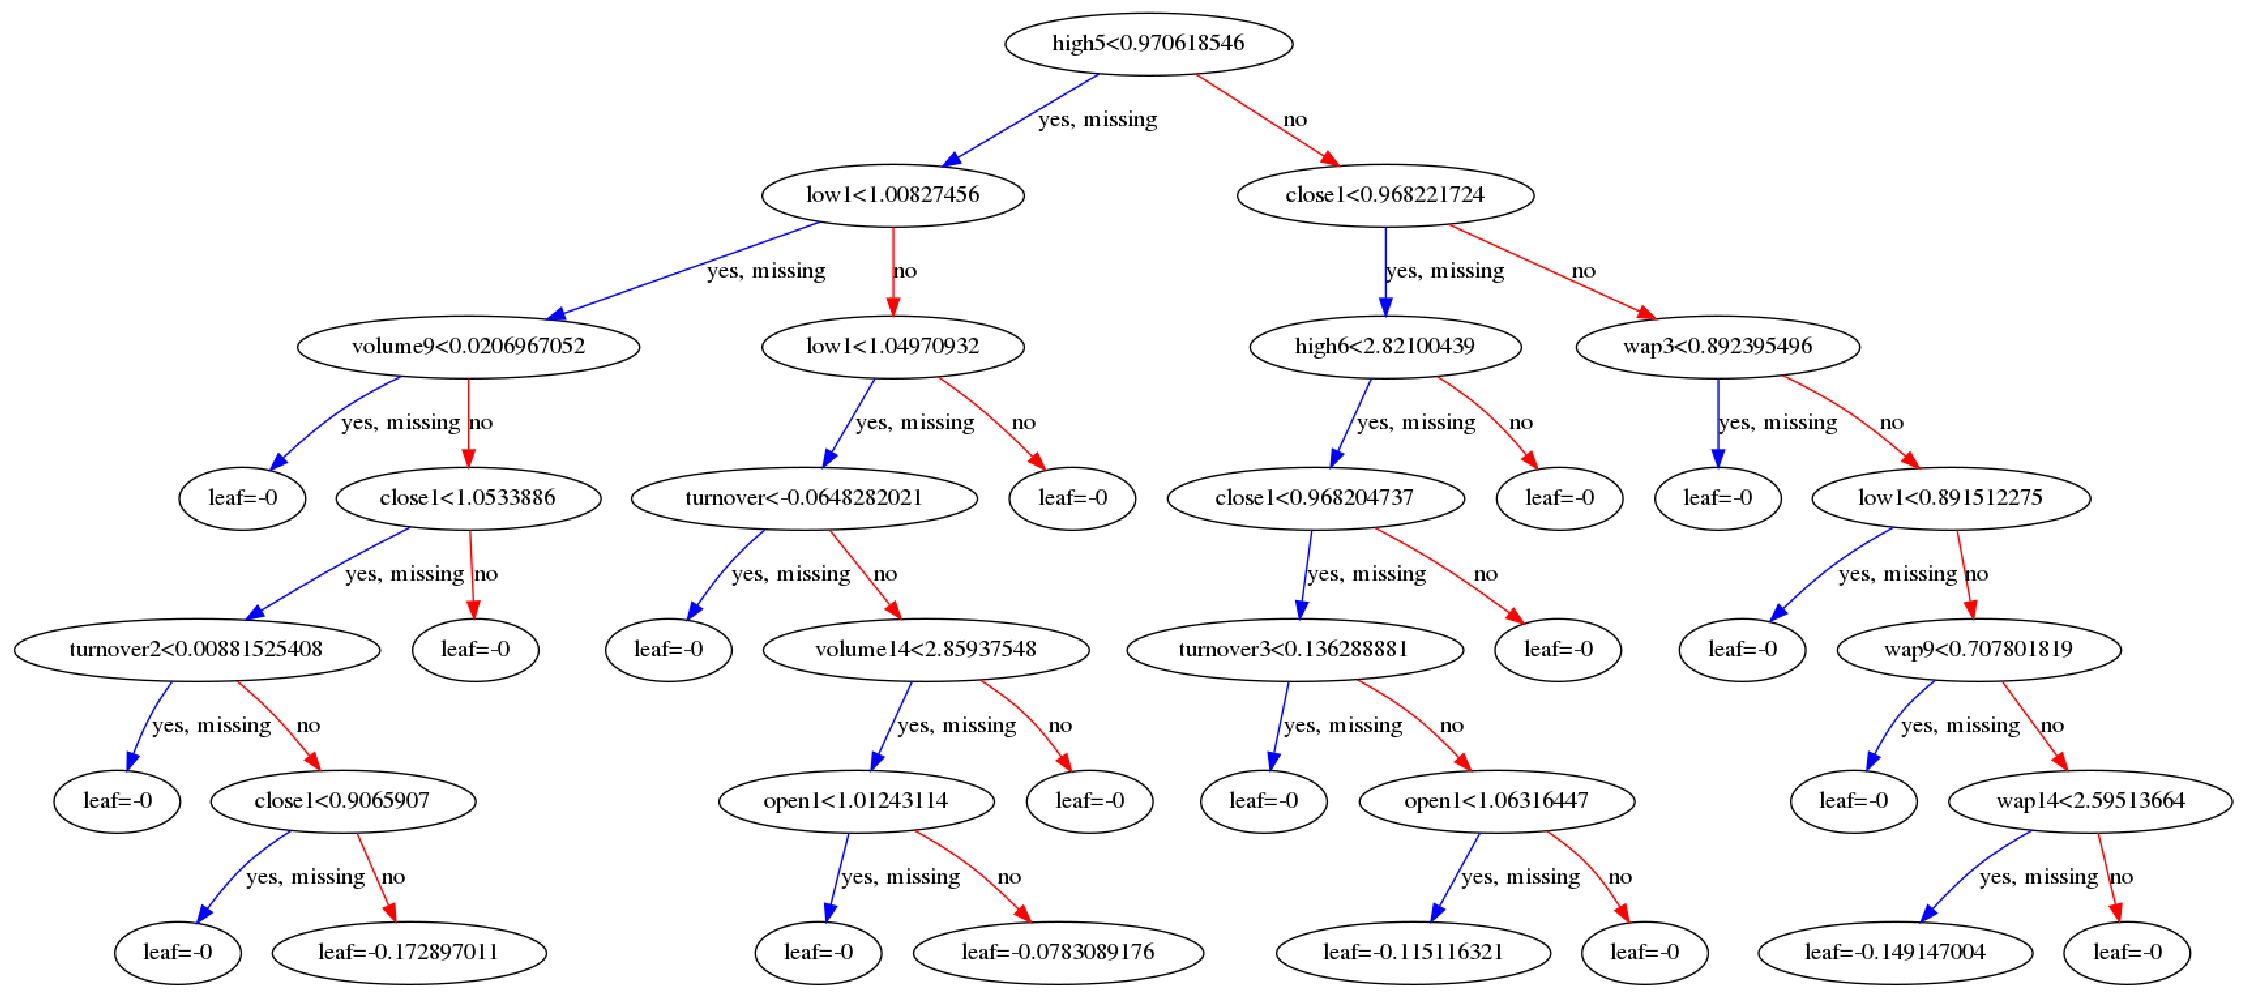

In [21]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=0)
plt.show()

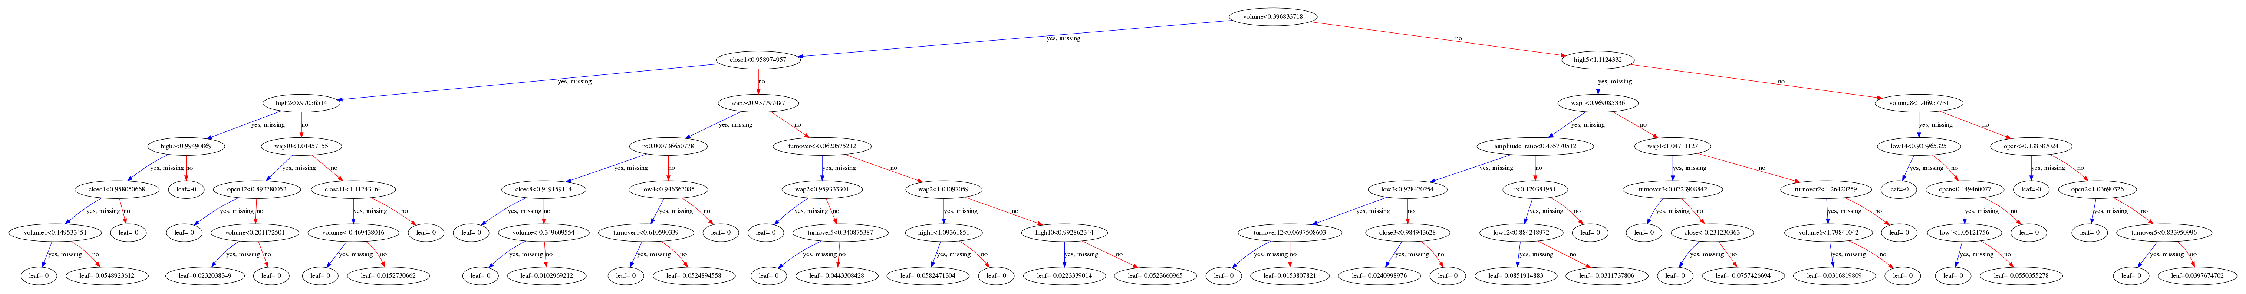

In [22]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=3)
plt.show()

In [23]:
df_tree = bst.trees_to_dataframe()

In [24]:
df_tree[(df_tree["Feature"] == "Leaf")&(df_tree["Gain"] > 0)]

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
178,3,59,3-59,Leaf,NaN,NaN,NaN,NaN,0.023204,971.0
183,3,64,3-64,Leaf,NaN,NaN,NaN,NaN,0.010297,1384.0
193,3,74,3-74,Leaf,NaN,NaN,NaN,NaN,0.015381,1198.0
205,3,86,3-86,Leaf,NaN,NaN,NaN,NaN,0.039767,478.0
248,4,42,4-42,Leaf,NaN,NaN,NaN,NaN,0.026149,989.0
...,...,...,...,...,...,...,...,...,...,...
11020,152,62,152-62,Leaf,NaN,NaN,NaN,NaN,0.002382,2595.0
11023,152,65,152-65,Leaf,NaN,NaN,NaN,NaN,0.014305,1528.0
11027,152,69,152-69,Leaf,NaN,NaN,NaN,NaN,0.011263,11788.0
11034,152,76,152-76,Leaf,NaN,NaN,NaN,NaN,0.026496,1756.0


In [25]:
all_tree_rounds = bst.best_ntree_limit + early
tr_step = []
te_step = []
fin_step = []
for i in range(1, all_tree_rounds):
    if i % 5==0:
        print("Tree numbers：", i)
    temp1 = bst.predict( xgb.DMatrix(data_tr[use_f]),ntree_limit= i)
    temp2 = bst.predict( xgb.DMatrix(data_te[use_f]),ntree_limit= i)
    temp3 = bst.predict( xgb.DMatrix(data_fin[use_f]),ntree_limit= i)
    corrcoef1 = np.corrcoef(temp1, data_tr["return"])[0,1]
    corrcoef2 = np.corrcoef(temp2, data_te["return"])[0,1]
    corrcoef3 = np.corrcoef(temp3, data_fin["return"])[0,1]
    tr_rmse = ((temp1 - data_tr["label"])*(temp1 - data_tr["label"])).mean()
    te_rmse = ((temp2 - data_te["label"])*(temp2 - data_te["label"])).mean()
    fin_rmse = ((temp3 - data_fin["label"])*(temp3 - data_fin["label"])).mean()
    tr_step.append([tr_rmse, corrcoef1])
    te_step.append([te_rmse, corrcoef2])
    fin_step.append([fin_rmse, corrcoef3])

Tree numbers： 5
Tree numbers： 10
Tree numbers： 15
Tree numbers： 20
Tree numbers： 25
Tree numbers： 30
Tree numbers： 35
Tree numbers： 40
Tree numbers： 45
Tree numbers： 50
Tree numbers： 55
Tree numbers： 60
Tree numbers： 65
Tree numbers： 70
Tree numbers： 75
Tree numbers： 80
Tree numbers： 85
Tree numbers： 90
Tree numbers： 95
Tree numbers： 100
Tree numbers： 105
Tree numbers： 110
Tree numbers： 115
Tree numbers： 120
Tree numbers： 125
Tree numbers： 130
Tree numbers： 135
Tree numbers： 140
Tree numbers： 145
Tree numbers： 150


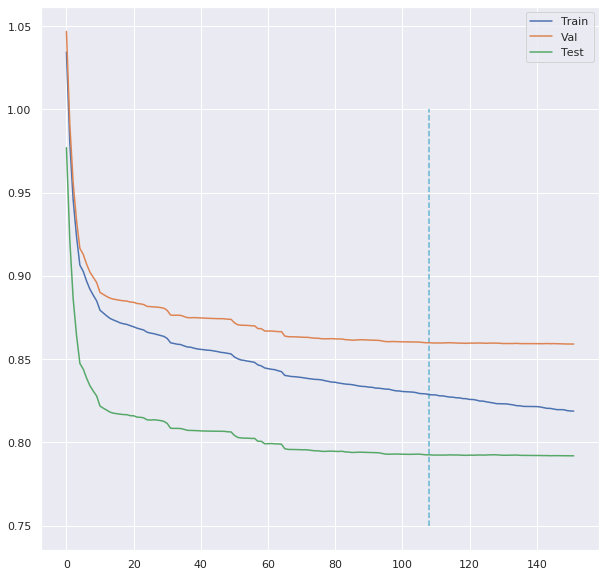

In [30]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.plot(np.array(tr_step)[:,0], label="Train")
plt.plot(np.array(te_step)[:,0], label="Val")
plt.plot(np.array(fin_step)[:,0], label="Test")
plt.vlines(bst.best_ntree_limit, 0.75, 1, colors = "c", linestyles = "dashed")
plt.legend()

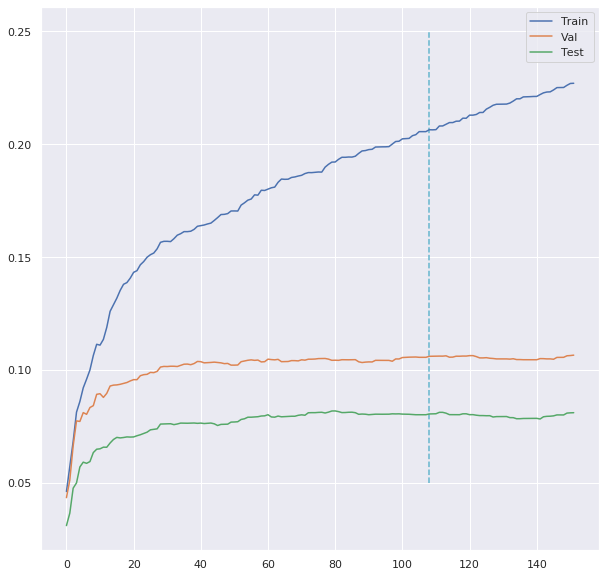

In [32]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.plot(np.array(tr_step)[:,1], label="Train")
plt.plot(np.array(te_step)[:,1], label="Val")
plt.plot(np.array(fin_step)[:,1], label="Test")
plt.vlines(bst.best_ntree_limit, 0.05, 0.25, colors = "c", linestyles = "dashed")
plt.legend()